# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
np.arange(50, 1000, 50)

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.442873
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [19]:
a = np.array([1,2,3])
b = np.array([1,2,3])
np.sum(a, axis=0)

6

In [14]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.313253 analytic: -2.313253, relative error: 1.161098e-09
numerical: -1.107203 analytic: -1.107203, relative error: 3.012331e-09
numerical: 2.333656 analytic: 2.333656, relative error: 2.384621e-08
numerical: 1.311018 analytic: 1.311018, relative error: 1.329776e-08
numerical: 1.585802 analytic: 1.585802, relative error: 1.832723e-08
numerical: -0.896505 analytic: -0.896505, relative error: 1.807021e-08
numerical: 1.136013 analytic: 1.136012, relative error: 6.319881e-08
numerical: 1.122704 analytic: 1.122704, relative error: 3.647617e-08
numerical: 0.902162 analytic: 0.902162, relative error: 6.984816e-08
numerical: -2.158981 analytic: -2.158981, relative error: 2.030294e-08
numerical: -0.315468 analytic: -0.315468, relative error: 4.767876e-09
numerical: 1.879142 analytic: 1.879142, relative error: 1.980715e-08
numerical: 0.351663 analytic: 0.351663, relative error: 9.066109e-09
numerical: -5.426680 analytic: -5.426680, relative error: 5.487411e-10
numerical: 3.347613 an

In [24]:
X = X_train

In [25]:
f = X.dot(W)
f -= np.max(f, axis=1)
# cor_clas_scores = f[np.arange(len(num_train)), y]
# f_exp = np.exp(f)
# cor_clas_scores_exp = np.exp(cor_clas_scores)
# loss = np.mean(-np.log(cor_clas_scores_exp/np.sum(f_exp, axis = 1)))

ValueError: operands could not be broadcast together with shapes (49000,10) (49000,) (49000,10) 

In [31]:
a = np.array([[1,2,3],[1,2,3],[1,2,3]])

In [38]:
b =  np.array([1,2,0])

In [37]:
(a.T/b).T

array([[1.        , 2.        , 3.        ],
       [0.5       , 1.        , 1.5       ],
       [0.33333333, 0.66666667, 1.        ]])

In [40]:
a[np.arange(len(a)), b] = a[np.arange(len(a)), b] - 1

In [41]:
a

array([[1, 1, 3],
       [1, 2, 2],
       [0, 2, 3]])

In [44]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.442873e+00 computed in 0.107284s
vectorized loss: 2.442873e+00 computed in 0.008024s
Loss difference: 0.000000
Gradient difference: 0.000000


In [47]:
from cs231n.classifiers import softmax

In [110]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
learning_rates = np.linspace(7.3e-7, 8.3e-7, 10)
regularization_strengths = np.linspace(2.2e4, 3.5e4, 10)
for rate in learning_rates:
    for strength in regularization_strengths:
        svm = Softmax()
        svm.train(X_train, y_train, learning_rate=rate, reg=strength,
                          num_iters=100, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        results[(rate, strength)] = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
best_params = max(results.keys(), key = (lambda x: results[x][1]))
best_val = results[best_params][1]
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 7.300000e-07 reg 2.200000e+04 train accuracy: 0.322061 val accuracy: 0.328000
lr 7.300000e-07 reg 2.344444e+04 train accuracy: 0.329388 val accuracy: 0.347000
lr 7.300000e-07 reg 2.488889e+04 train accuracy: 0.321000 val accuracy: 0.337000
lr 7.300000e-07 reg 2.633333e+04 train accuracy: 0.326224 val accuracy: 0.348000
lr 7.300000e-07 reg 2.777778e+04 train accuracy: 0.314367 val accuracy: 0.338000
lr 7.300000e-07 reg 2.922222e+04 train accuracy: 0.312612 val accuracy: 0.320000
lr 7.300000e-07 reg 3.066667e+04 train accuracy: 0.318224 val accuracy: 0.332000
lr 7.300000e-07 reg 3.211111e+04 train accuracy: 0.297898 val accuracy: 0.319000
lr 7.300000e-07 reg 3.355556e+04 train accuracy: 0.298918 val accuracy: 0.318000
lr 7.300000e-07 reg 3.500000e+04 train accuracy: 0.321837 val accuracy: 0.321000
lr 7.411111e-07 reg 2.200000e+04 train accuracy: 0.324163 val accuracy: 0.333000
lr 7.411111e-07 reg 2.344444e+04 train accuracy: 0.315796 val accuracy: 0.321000
lr 7.411111e-07 reg 2.488889

In [111]:
best_params

(7.855555555555555e-07, 24888.88888888889)

In [112]:
best_svm = Softmax()
best_svm.train(X_train, y_train, learning_rate=best_params[0], reg=best_params[1],
                          num_iters=1000, verbose=False)

In [113]:
y_train_pred = best_svm.predict(X_train)
y_val_pred = best_svm.predict(X_val)
print(np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))

0.3236122448979592 0.328


In [115]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.345000


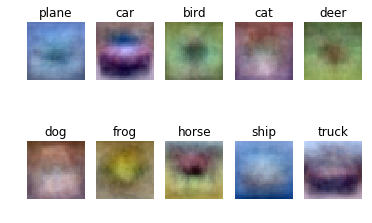

In [117]:
# Visualize the learned weights for each class
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])